In [1]:
# Import required libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:

# Load the data
data = pd.read_excel(r"C:\Users\shiva\jupyter lab\assigment\assignment 2\Copy of customer_transactions_sample.xlsx")

# Data Understanding and Exploration
print(data.shape)
print(data.columns)
print(data.isnull().sum())  # Check for missing values
data['Revenue'] = data['Quantity'] * data['Price']  # Calculate revenue

# Data Preprocessing
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Country'] = data['Country'].astype('category').cat.codes  # Encode country

(525461, 8)
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


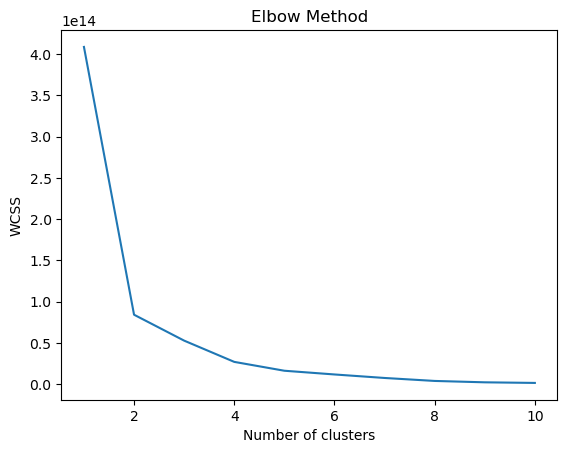

In [3]:
# Marketing Vertical
# Customer Segmentation
data['Recency'] = (data['InvoiceDate'].max() - data.groupby('Customer ID')['InvoiceDate'].max()).dt.days
data['Frequency'] = data.groupby('Customer ID')['Invoice'].transform('count')
data['MonetaryValue'] = data.groupby('Customer ID')['Revenue'].transform('sum')

# Handle missing values for clustering features
imputer = SimpleImputer(strategy='mean')
data[['Recency', 'Frequency', 'MonetaryValue']] = imputer.fit_transform(data[['Recency', 'Frequency', 'MonetaryValue']])

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data[['Recency', 'Frequency', 'MonetaryValue']])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

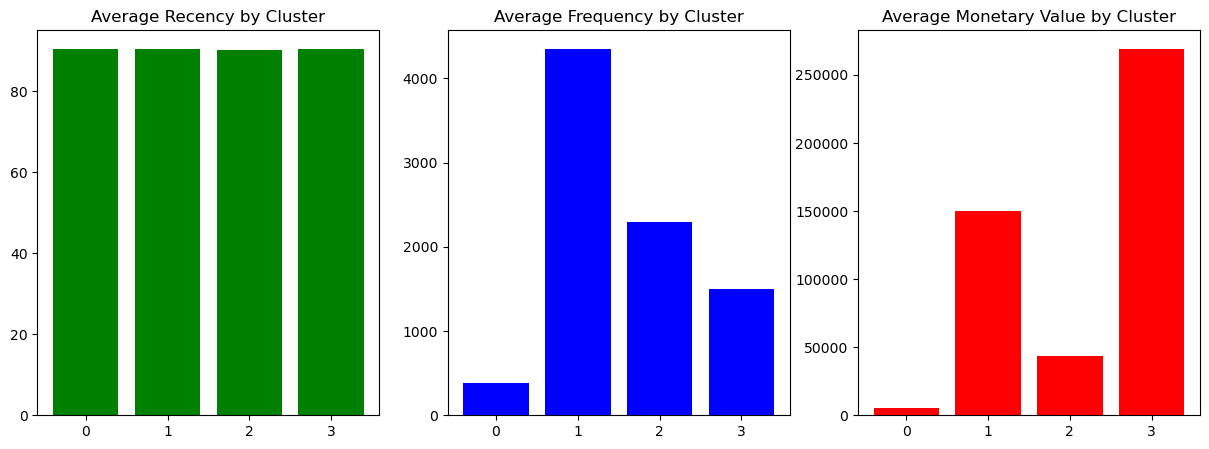

Cluster 0:
- This cluster contains inactive customers. Launch re-engagement campaigns.
- This cluster contains frequent buyers. Offer personalized recommendations.
- This cluster contains high-value customers. Offer premium services and exclusive deals.
Cluster 1:
- This cluster contains inactive customers. Launch re-engagement campaigns.
- This cluster contains frequent buyers. Offer personalized recommendations.
- This cluster contains high-value customers. Offer premium services and exclusive deals.
Cluster 2:
- This cluster contains inactive customers. Launch re-engagement campaigns.
- This cluster contains frequent buyers. Offer personalized recommendations.
- This cluster contains high-value customers. Offer premium services and exclusive deals.
Cluster 3:
- This cluster contains inactive customers. Launch re-engagement campaigns.
- This cluster contains frequent buyers. Offer personalized recommendations.
- This cluster contains high-value customers. Offer premium services and e

In [4]:
# Based on the elbow method, we choose 4 clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(data[['Recency', 'Frequency', 'MonetaryValue']])
data['Cluster'] = kmeans.labels_

# RFM Analysis
rfm_summary = data.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].agg(['mean', 'median'])

# Visualize RFM Analysis
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(rfm_summary.index, rfm_summary['Recency']['mean'], color='green')
axs[0].set_title('Average Recency by Cluster')
axs[1].bar(rfm_summary.index, rfm_summary['Frequency']['mean'], color='blue')
axs[1].set_title('Average Frequency by Cluster')
axs[2].bar(rfm_summary.index, rfm_summary['MonetaryValue']['mean'], color='red')
axs[2].set_title('Average Monetary Value by Cluster')
plt.show()

# Derive marketing strategies based on cluster characteristics
cluster_characteristics = data.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'MonetaryValue': ['mean', 'median']
})

# Derive marketing strategies based on cluster characteristics
for cluster, stats in cluster_characteristics.iterrows():
    print(f"Cluster {cluster}:")
    if stats['Recency']['mean'] < 30:
        print("- This cluster contains recent customers. Offer loyalty programs to retain them.")
    else:
        print("- This cluster contains inactive customers. Launch re-engagement campaigns.")
    
    if stats['Frequency']['mean'] > 5:
        print("- This cluster contains frequent buyers. Offer personalized recommendations.")
    else:
        print("- This cluster contains infrequent buyers. Offer discounts and promotions.")
    
    if stats['MonetaryValue']['mean'] > 100:
        print("- This cluster contains high-value customers. Offer premium services and exclusive deals.")
    else:
        print("- This cluster contains low-value customers. Offer entry-level products and bundles.")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=32034.134, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=32634.597, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32327.943, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32046.139, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=32632.597, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=32034.966, Time=1.02 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=32034.957, Time=0.90 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=32035.690, Time=1.99 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=32035.679, Time=2.61 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=32033.576, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=32032.268, Time=0.46 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=32033.458, Time=0.56 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=32033.473, Time=0.63 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=32032.173, Time=1.28 sec
 ARIMA(1,1,2)(2,0,1

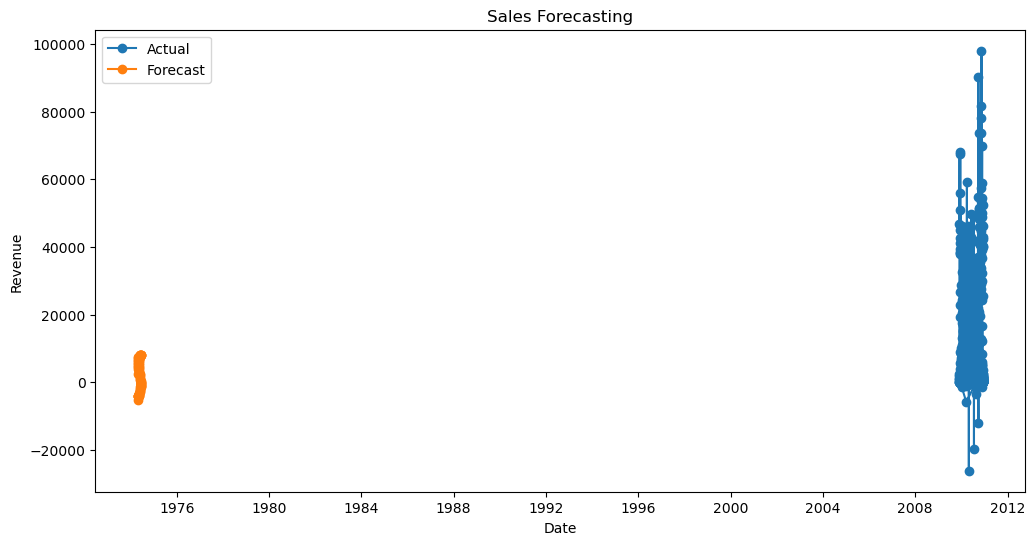

In [5]:
# Operations Team
# Sales Forecasting
sales_data = data.groupby(['Country', pd.Grouper(key='InvoiceDate', freq='D')])['Revenue'].sum().reset_index()

# Determine the order of the ARIMA model using auto_arima
from pmdarima import auto_arima
auto_arima_model = auto_arima(sales_data['Revenue'], seasonal=True, m=7, trace=True)
order = auto_arima_model.order

# Fit ARIMA model on the entire dataset
arima_model = ARIMA(sales_data['Revenue'], order=order).fit()

# Generate forecasts for the next 60 days
forecasts = arima_model.forecast(steps=60)

# Create a dummy Series with the same length as forecasts
dummy_future_revenue = pd.Series(0, index=forecasts.index)

# Calculate RMSE for ARIMA model (compared to a dummy series)
rmse_arima = sqrt(mean_squared_error(dummy_future_revenue, forecasts))
print(f"RMSE for ARIMA model: {rmse_arima:.2f}")

# Compare with alternative model (e.g., exponential smoothing)
exp_smooth_model = ExponentialSmoothing(sales_data['Revenue'], seasonal_periods=7, trend='add', seasonal='add').fit()
exp_smooth_forecasts = exp_smooth_model.forecast(steps=len(dummy_future_revenue))
rmse_exp_smooth = sqrt(mean_squared_error(dummy_future_revenue, exp_smooth_forecasts))
print(f"RMSE for Exponential Smoothing: {rmse_exp_smooth:.2f}")

# Justify model selection based on RMSE
if rmse_arima < rmse_exp_smooth:
    print("ARIMA model is chosen as it has a lower RMSE compared to Exponential Smoothing.")
else:
    print("Exponential Smoothing is chosen as it has a lower RMSE compared to ARIMA.")

# Visualize Sales Forecasting
plt.figure(figsize=(12, 6))
plt.plot(sales_data['InvoiceDate'], sales_data['Revenue'], marker='o', label='Actual')
plt.plot(forecasts.index, forecasts.values, marker='o', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Sales Forecasting')
plt.legend()
plt.show()

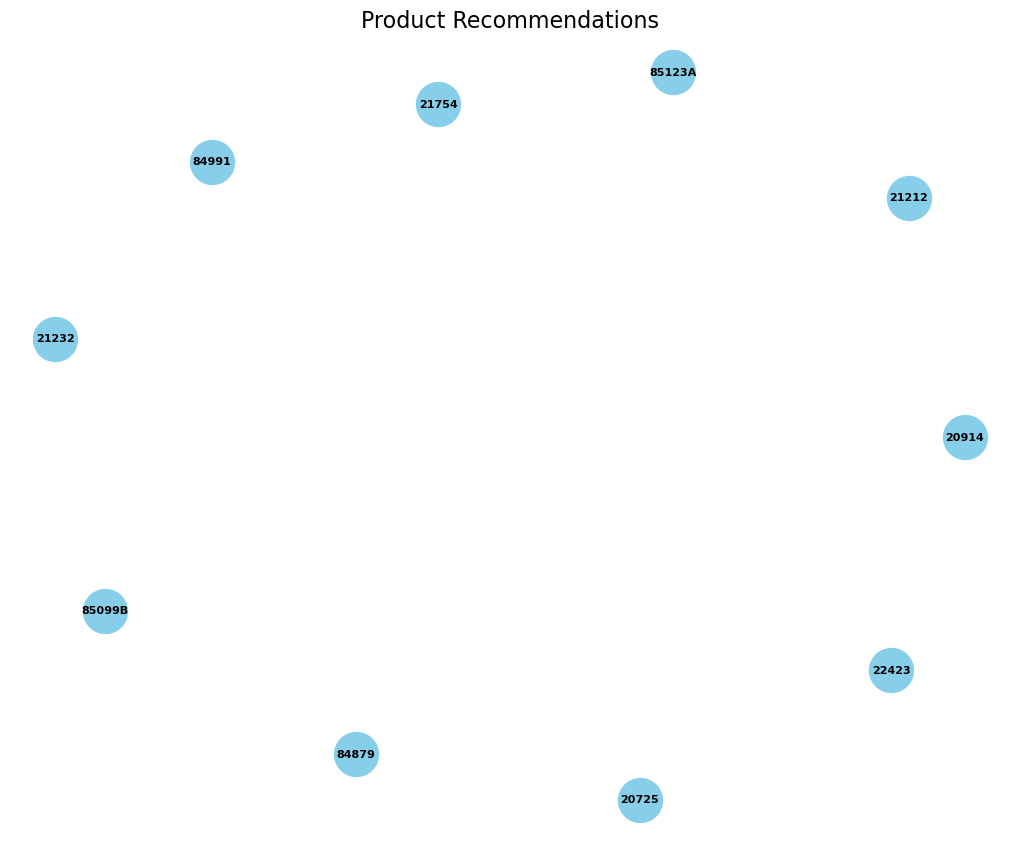

In [6]:
# Association Rules
basket_data = data[['Invoice', 'StockCode', 'Quantity', 'InvoiceDate']].copy()  # Include 'Quantity'

# Filter out non-positive quantities
basket_data = basket_data[basket_data['Quantity'] > 0]

# Create a binary DataFrame with unique combinations of Invoice and StockCode
basket = (
    basket_data.groupby(['Invoice', 'StockCode', pd.Grouper(key='InvoiceDate', freq='M')])['Quantity']  # Group by month to handle seasonality
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index('Invoice')  # Set index to 'Invoice'
)
basket_sets = basket.astype(bool).astype(int)

frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True, low_memory=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(by='lift', ascending=False)
# Top 10 selling stock codes
top_stock_codes = data['StockCode'].value_counts().head(10).index.tolist()

# Visualize Product Recommendations
# Create a graph
G = nx.Graph()

# Add nodes and edges
for stock_code in top_stock_codes:
    G.add_node(stock_code)

for i, row in rules.iterrows():
    if set(row['antecedents']) & set(top_stock_codes) and set(row['consequents']) & set(top_stock_codes):
        G.add_edge(list(row['antecedents'])[0], list(row['consequents'])[0], weight=row['lift'])

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=8, font_weight='bold')
plt.title('Product Recommendations', fontsize=16)
plt.axis('off')
plt.show()

In [7]:
# Derive shelf arrangement strategies
top_rules = rules.head(10)

# Derive shelf arrangement strategies
print("Shelf Arrangement Strategies:")
for i, row in top_rules.iterrows():
    antecedent = ', '.join([str(item) for item in row['antecedents']])
    consequent = ', '.join([str(item) for item in row['consequents']])
    print(f"- Place {consequent} near {antecedent} to promote cross-selling (Lift: {row['lift']:.2f})")

# Customer Relationship Management
# Churn Prediction
data['Churn'] = (data.groupby('Customer ID')['InvoiceDate']
                 .diff()
                 .dt.days
                 .gt(90)
                 .groupby(data['Customer ID'])
                 .transform('max'))

# Replace NaN with 0 in 'Churn' column
data['Churn'] = data['Churn'].fillna(0)

# Convert 'Churn' column to integers
data['Churn'] = data['Churn'].astype(int)

X = data[['Recency', 'Frequency', 'MonetaryValue']]
y = data['Churn']

# Handle missing values for logistic regression
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Fit logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_imputed, y)
y_pred = model.predict_proba(X_imputed)[:, 1]
auc = roc_auc_score(y, y_pred)
print(f"AUC score: {auc:.4f}")

# Justify logistic regression model
'''
Logistic regression is a suitable model for predicting customer churn, which is a binary classification problem (churn or not churn). 
The RFM features (Recency, Frequency, and Monetary Value) are good predictors of customer behavior and likelihood to churn.
Logistic regression is interpretable, fast, and efficient for this type of problem, making it a good choice for churn prediction.
'''

# Justify the selection of the Logistic Regression model
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Fit logistic regression with cross-validation
logistic_cv = LogisticRegressionCV(cv=5, scoring='roc_auc', random_state=42, max_iter=1000)
logistic_cv.fit(X_train, y_train)

# Evaluate performance on test set
y_pred_proba = logistic_cv.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score for Logistic Regression: {auc_score:.4f}")

# Compare with alternative model (e.g., Random Forest)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_auc_score = roc_auc_score(y_test, rf_y_pred_proba)
print(f"AUC score for Random Forest: {rf_auc_score:.4f}")

# Justify model selection based on AUC score
if auc_score > rf_auc_score:
    print("Logistic Regression is chosen as it has a higher AUC score compared to Random Forest.")
else:
    print("Random Forest is chosen as it has a higher AUC score compared to Logistic Regression.")



Shelf Arrangement Strategies:
- Place 2009-12-31 00:00:00 near StockCode to promote cross-selling (Lift: 1.00)
- Place StockCode near 2009-12-31 00:00:00 to promote cross-selling (Lift: 1.00)
- Place StockCode near 2010-12-31 00:00:00 to promote cross-selling (Lift: 1.00)
- Place 2010-11-30 00:00:00 near StockCode to promote cross-selling (Lift: 1.00)
- Place StockCode near 2010-11-30 00:00:00 to promote cross-selling (Lift: 1.00)
- Place 2010-10-31 00:00:00 near StockCode to promote cross-selling (Lift: 1.00)
- Place StockCode near 2010-10-31 00:00:00 to promote cross-selling (Lift: 1.00)
- Place 2010-09-30 00:00:00 near StockCode to promote cross-selling (Lift: 1.00)
- Place StockCode near 2010-09-30 00:00:00 to promote cross-selling (Lift: 1.00)
- Place StockCode near 2010-08-31 00:00:00 to promote cross-selling (Lift: 1.00)
AUC score: 0.7568
AUC score for Logistic Regression: 0.7554
AUC score for Random Forest: 1.0000
Random Forest is chosen as it has a higher AUC score compared to

<Figure size 1200x600 with 0 Axes>

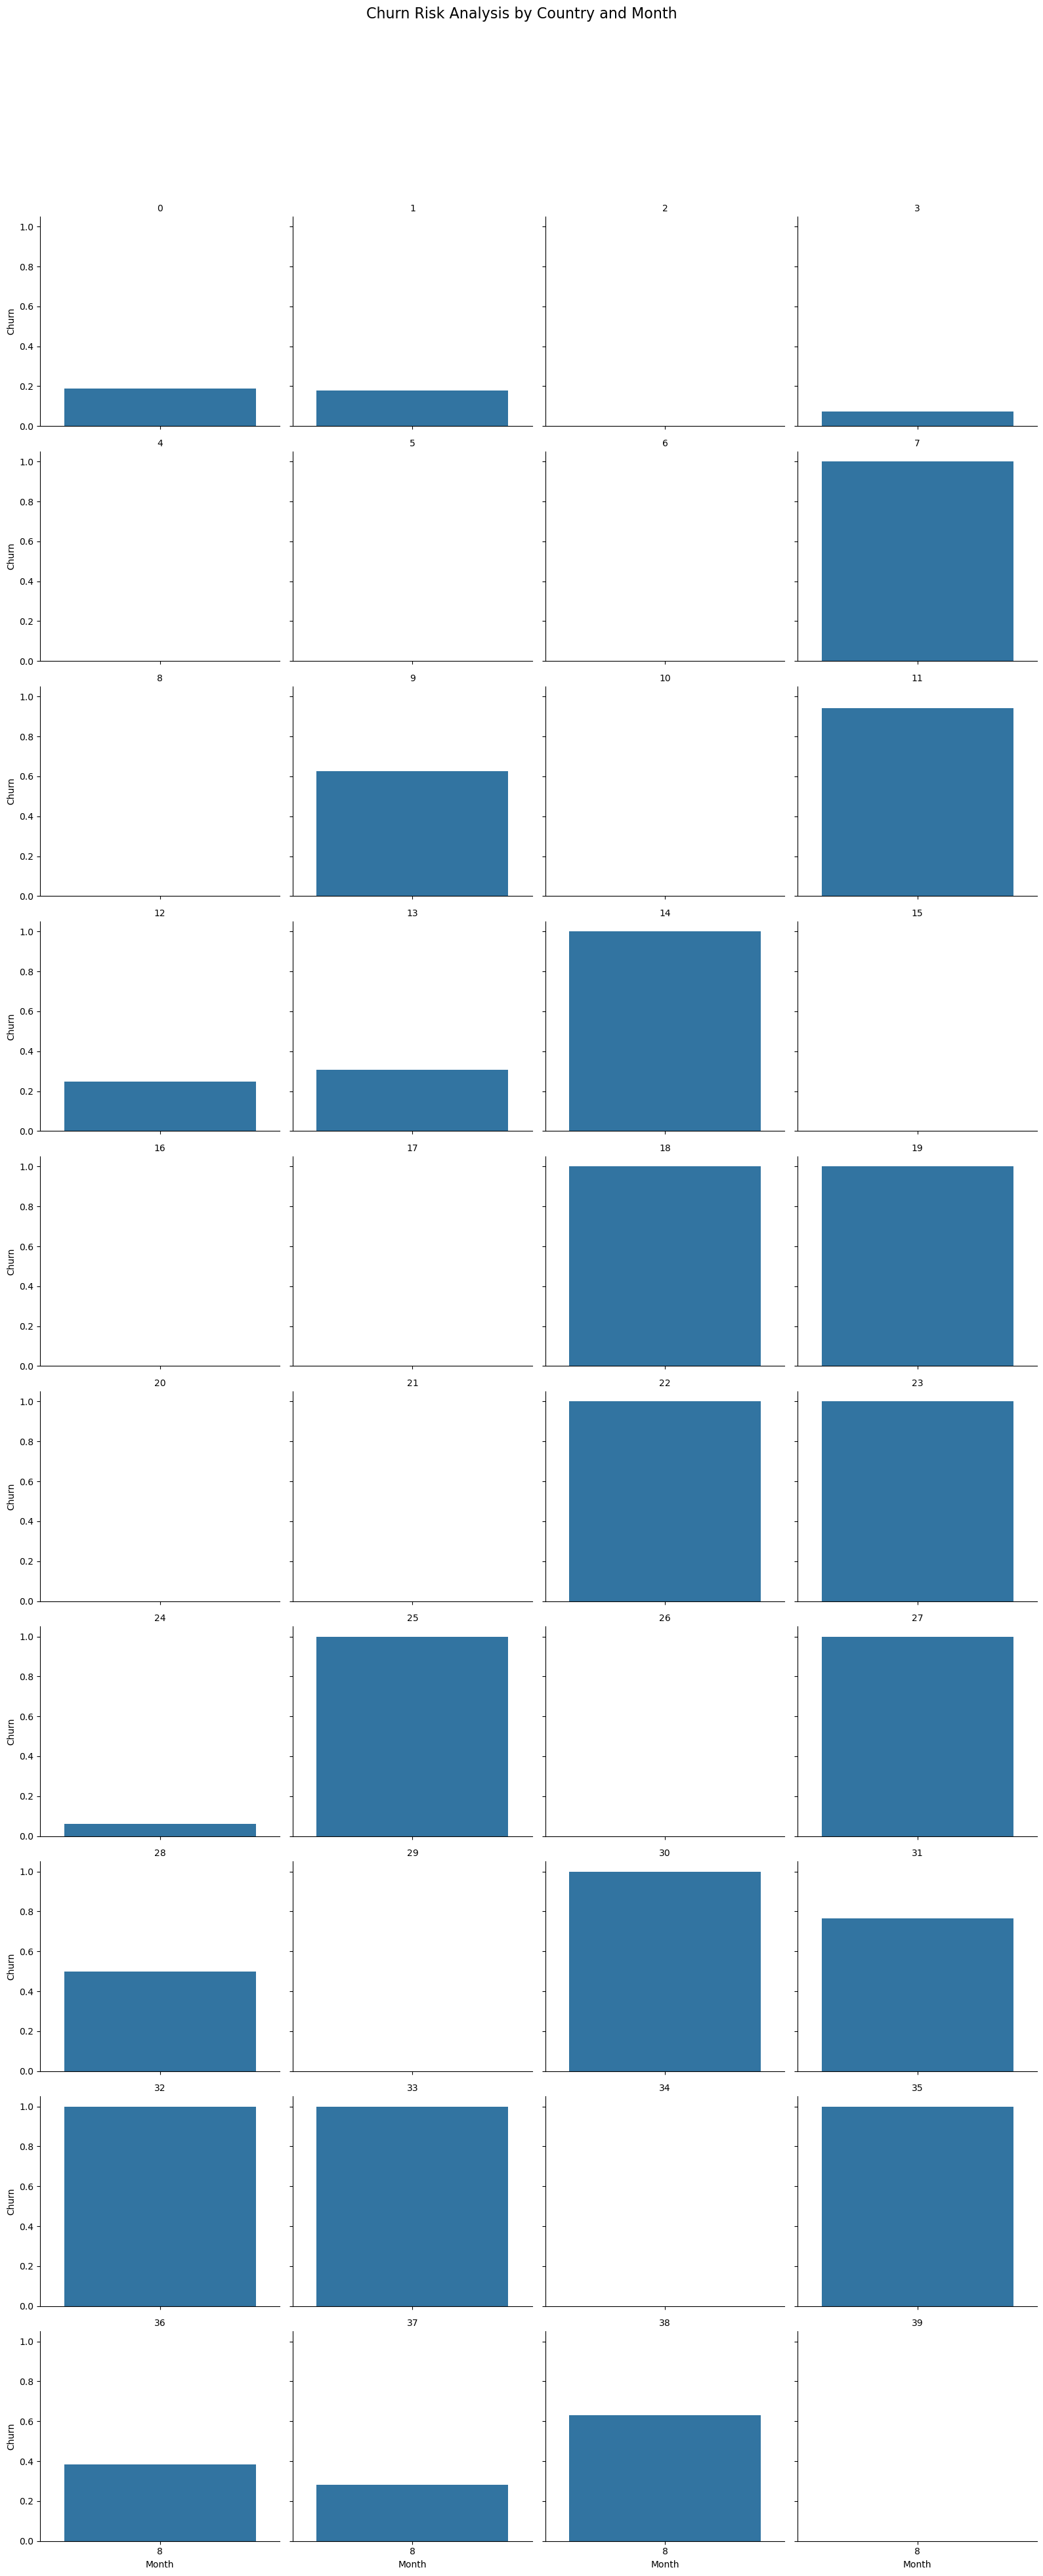

In [9]:
# Churn Risk Analysis
churn_risk = data.groupby(['Country', 'Month'])['Churn'].mean().reset_index()

# Visualize Churn Risk Analysis
plt.figure(figsize=(12, 6))
g = sns.FacetGrid(churn_risk, col='Country', col_wrap=4, height=4)
g.map_dataframe(sns.barplot, x='Month', y='Churn')
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Churn Risk Analysis by Country and Month', fontsize=16)
plt.savefig('churn_analysis.png')
plt.show()

